<h1>Load previously saved LDA results</h1>

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

from lda_for_fragments import Ms2Lda
from lda_utils import estimate_alpha_from_counts
import numpy as np
import pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ms2lda = Ms2Lda.resume_from('results/beer3pos.project')

Project loaded from results/beer3pos.project time taken = 17.0908110142
 - input_filenames = 
	../input/final/Beer_3_full1_5_2E5_pos_fragments.csv
	../input/final/Beer_3_full1_5_2E5_pos_losses.csv
	../input/final/Beer_3_full1_5_2E5_pos_ms1.csv
	../input/final/Beer_3_full1_5_2E5_pos_ms2.csv
 - df.shape = (1588, 3171)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - last_saved_timestamp = Thu Aug  6 16:13:04 2015


In [3]:
D = ms2lda.model.D
K = ms2lda.model.K
alpha = ms2lda.model.alpha
beta = ms2lda.model.beta
samples = ms2lda.model.samples

<h1>Update posterior probabilities</h1>

This happens after the sampling in the LDA.

In [4]:
def get_posterior_probs(samp_cdk, samp_ckn):

    # update theta
    theta = samp_cdk + alpha 
    theta /= np.sum(theta, axis=1)[:, np.newaxis]

    # update phi
    phi = samp_ckn + beta
    phi /= np.sum(phi, axis=1)[:, np.newaxis]

    # update posterior alpha
    alpha_new = estimate_alpha_from_counts(D, K, alpha, samp_cdk)      
    return theta, phi, alpha_new

In [5]:
def update_parameters(n_burn, samples):

    # use the last sample only
    if n_burn == 0:
        print "Using only the last sample"
        last_samp = samples[-1]
        theta, phi, alpha_new = get_posterior_probs(last_samp.cdk, last_samp.ckn)            
        return phi, theta, alpha_new

    print "Using all samples"
    thetas = []
    phis = []
    alphas = []
    for samp in samples:            
        theta, phi, alpha_new = get_posterior_probs(samp.cdk, samp.ckn)
        thetas.append(theta)
        phis.append(phi)
        if not np.isnan(alpha_new).any():           
            alphas.append(alpha_new)

    # average over the results
    S = len(samples)
    avg_theta = np.zeros_like(thetas[0])
    avg_phi = np.zeros_like(phis[0])
    avg_posterior_alpha = np.zeros_like(alphas[0])

    for theta in thetas:
        avg_theta += theta
    avg_theta /= len(thetas)

    for phi in phis:
        avg_phi += phi
    avg_phi /= len(phis)

    for alpha in alphas:
        avg_posterior_alpha += alpha
    avg_posterior_alpha /= len(alphas)

    return avg_phi, avg_theta, avg_posterior_alpha

In [16]:
topic_word_, doc_topic_, posterior_alpha = update_parameters(250, samples)

Using all samples


In [17]:
print topic_word_.shape
print np.sum(topic_word_[0, :])

(300, 3171)
1.0


In [18]:
print doc_topic_.shape
print np.sum(doc_topic_[0, :])

(1588, 300)
1.0


<h1>Thresholding</h1>

This happens inside visualisation

In [19]:
def threshold_matrix(matrix, epsilon=0.0):
    thresholded = matrix.copy()
    n_row, n_col = thresholded.shape
    for i in range(n_row):
        row = thresholded[i, :]
        if epsilon > 0:
            small = row < epsilon
            row[small] = 0
        else:
            smallest_val = np.min(row)
            smallest_arr = np.ones_like(row) * smallest_val
            close = np.isclose(row, smallest_arr)
            row[close] = 0        
    return thresholded

<h2>Threshold the topic-word matrix using the smallest value in each row</h2>

nnz count = 40768


<matplotlib.colorbar.Colorbar instance at 0x7f4984326950>

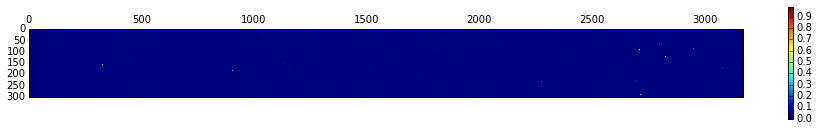

In [35]:
th_topic_word = 0.0 # if 0, then use the smallest value in each row as the threshold
topic_word = threshold_matrix(topic_word_, epsilon=th_topic_word)

print "nnz count = " + str(np.count_nonzero(topic_word))
plt.matshow(topic_word)
plt.colorbar()

<h2>Threshold the doc-topic matrix using the smallest value in each row</h2>

nnz count = 42944


<matplotlib.colorbar.Colorbar instance at 0x7f498418ccf8>

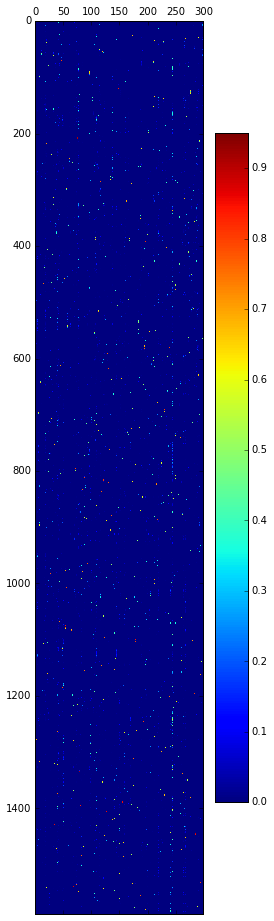

In [36]:
th_doc_topic = 0.0
doc_topic = threshold_matrix(doc_topic_, epsilon=th_doc_topic)
print "nnz count = " + str(np.count_nonzero(doc_topic))
plt.matshow(doc_topic)
plt.colorbar()

<h2>Threshold the doc-topic matrix with a fixed threshold of 0.05</h2>

nnz count = 4749


<matplotlib.colorbar.Colorbar instance at 0x7f49840033f8>

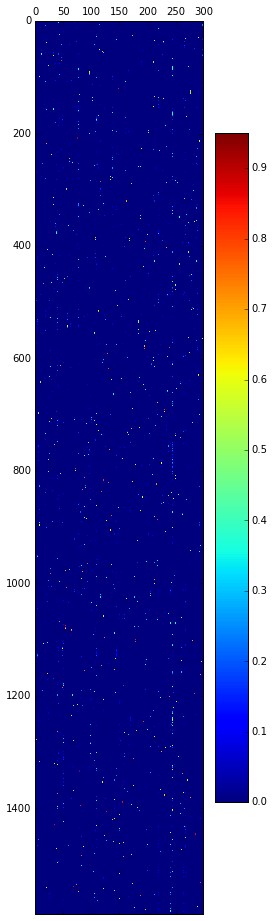

In [37]:
th_doc_topic = 0.05
doc_topic = threshold_matrix(doc_topic_, epsilon=th_doc_topic)

print "nnz count = " + str(np.count_nonzero(doc_topic))
plt.matshow(doc_topic)
plt.colorbar()